<a href="https://colab.research.google.com/github/agayev169/pytorch_examples/blob/master/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU

In [1]:
!nvidia-smi

Fri Jan  3 20:04:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    43W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## Constants

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
epochs_n   = 20
lr         = 0.0002

## Model

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1    = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2    = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2      = nn.BatchNorm2d(128)
        self.conv3    = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3      = nn.BatchNorm2d(256)
        self.conv4    = nn.Conv2d(256, 1, 4, 2, 1)

    
    def forward(self, x):
        x = self.conv1(x)                # x, 64, 14, 14
        x = F.relu(x)
        x = self.conv2(x)                # x, 128, 7, 7
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)                # x, 256, 3, 3
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)                # x, 1, 1, 1
        x = torch.sigmoid(x)
        return x.view(-1, 1).squeeze(1)

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1_t  = nn.ConvTranspose2d(100, 512, 5, 1, 0)
        self.bn1      = nn.BatchNorm2d(512)
        self.conv2_t  = nn.ConvTranspose2d(512, 256, 4, 2, 0)
        self.bn2      = nn.BatchNorm2d(256)
        self.conv3_t  = nn.ConvTranspose2d(256, 128, 4, 2, 0)
        self.bn3      = nn.BatchNorm2d(128)
        self.conv4_t  = nn.ConvTranspose2d(128, 1, 3, 1, 0)


    def forward(self, x):                  # x: x, 100, 1, 1
        x = self.conv1_t(x)                # x, 256, 5, 5
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2_t(x)                # x, 128, 12, 12
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3_t(x)                # x, 64, 26, 26
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4_t(x)                # x, 1, 28, 28
        x = torch.tanh(x)
        return x


### Weights initialization

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Test

### Train

In [0]:
def train(generator, discriminator, device, train_loader, opt_gen, opt_disc, epochs_n, criterion=None, criterion_sum=None):
    if not criterion:
        criterion = nn.BCELoss()
        criterion_sum = nn.BCELoss(reduction="sum")

    fixed_noise = torch.normal(mean=0, std=1, size=(5, 100, 1, 1)).to(device)
    results = np.empty(shape=(epochs_n + 1, 5, 28, 28))
    results[0] = generator(fixed_noise).to("cpu").detach().numpy().reshape(5, 28, 28)

    for epoch in range(epochs_n):
        epoch_begin = time.time()

        total_loss_gen  = 0
        total_loss_disc = 0

        D_x = 0
        D_z = 0

        for x, _ in train_loader:

            fake_labels = torch.zeros(x.size()[0]).to(device)
            real_labels = torch.ones (x.size()[0]).to(device)

            # generator
            opt_gen.zero_grad()
            z = torch.normal(mean=0, std=1, size=(x.size()[0], 100, 1, 1)).to(device)
            gen_out = generator(z)
            disc_out = discriminator(gen_out)
            D_z += np.sum(disc_out.to("cpu").detach().numpy())
            loss_gen = criterion(disc_out, real_labels)
            total_loss_gen += criterion_sum(disc_out, real_labels).item()

            loss_gen.backward()
            opt_gen.step()

            # discriminator
            opt_disc.zero_grad()
            x = x.to(device)
            disc_out_real = discriminator(x)
            D_x += np.sum(disc_out_real.to("cpu").detach().numpy())
            loss_disc_real = criterion(disc_out_real, real_labels)
            total_loss_disc += criterion_sum(disc_out_real, real_labels).item()

            z = torch.normal(mean=0, std=1, size=(x.size()[0], 100, 1, 1)).to(device)
            gen_out = generator(z)
            disc_out_fake = discriminator(gen_out.detach())
            loss_disc_fake = criterion(disc_out_fake, fake_labels)
            total_loss_disc += criterion_sum(disc_out_fake, fake_labels).item()

            disc_total_loss = loss_disc_fake + loss_disc_real
            disc_total_loss.backward()
            opt_disc.step()

        D_z /= len(train_loader.dataset)
        D_x /= len(train_loader.dataset)


        total_loss_gen  = total_loss_gen  / len(train_loader.dataset)
        total_loss_disc = total_loss_disc / len(train_loader.dataset)

        results[epoch + 1] = generator(fixed_noise).to("cpu").detach().numpy().reshape(5, 28, 28)
        
        epoch_time = time.time() - epoch_begin
        print(f"TRAIN --- epoch: {(epoch + 1):3d} --- generator loss: {total_loss_gen:.6f} --- discriminator loss: {total_loss_disc:.6f} --- D_x: {D_x:.3f} --- D_z: {D_z:.3f} --- time: {epoch_time:.4f}")
        epoch += 1

    return results

## Data

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=True, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,), (0.5,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

## Training

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

generator.apply(weights_init)
discriminator.apply(weights_init)

opt_gen  = optim.Adam(    generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

imgs = train(generator, discriminator, device, train_loader, opt_gen, opt_disc, epochs_n)

TRAIN --- epoch:   1 --- generator loss: 2.110083 --- discriminator loss: 0.676168 --- D_x: 0.750 --- D_z: 0.206 --- time: 40.6636
TRAIN --- epoch:   2 --- generator loss: 1.633697 --- discriminator loss: 0.730285 --- D_x: 0.729 --- D_z: 0.263 --- time: 40.5990
TRAIN --- epoch:   3 --- generator loss: 1.678286 --- discriminator loss: 0.701786 --- D_x: 0.736 --- D_z: 0.252 --- time: 40.3305
TRAIN --- epoch:   4 --- generator loss: 1.755483 --- discriminator loss: 0.682575 --- D_x: 0.744 --- D_z: 0.241 --- time: 40.8029
TRAIN --- epoch:   5 --- generator loss: 1.811571 --- discriminator loss: 0.645977 --- D_x: 0.755 --- D_z: 0.235 --- time: 40.5691
TRAIN --- epoch:   6 --- generator loss: 1.843761 --- discriminator loss: 0.648993 --- D_x: 0.755 --- D_z: 0.231 --- time: 40.7460
TRAIN --- epoch:   7 --- generator loss: 1.885019 --- discriminator loss: 0.626899 --- D_x: 0.762 --- D_z: 0.226 --- time: 40.3433
TRAIN --- epoch:   8 --- generator loss: 1.934007 --- discriminator loss: 0.611560 

## Generating images

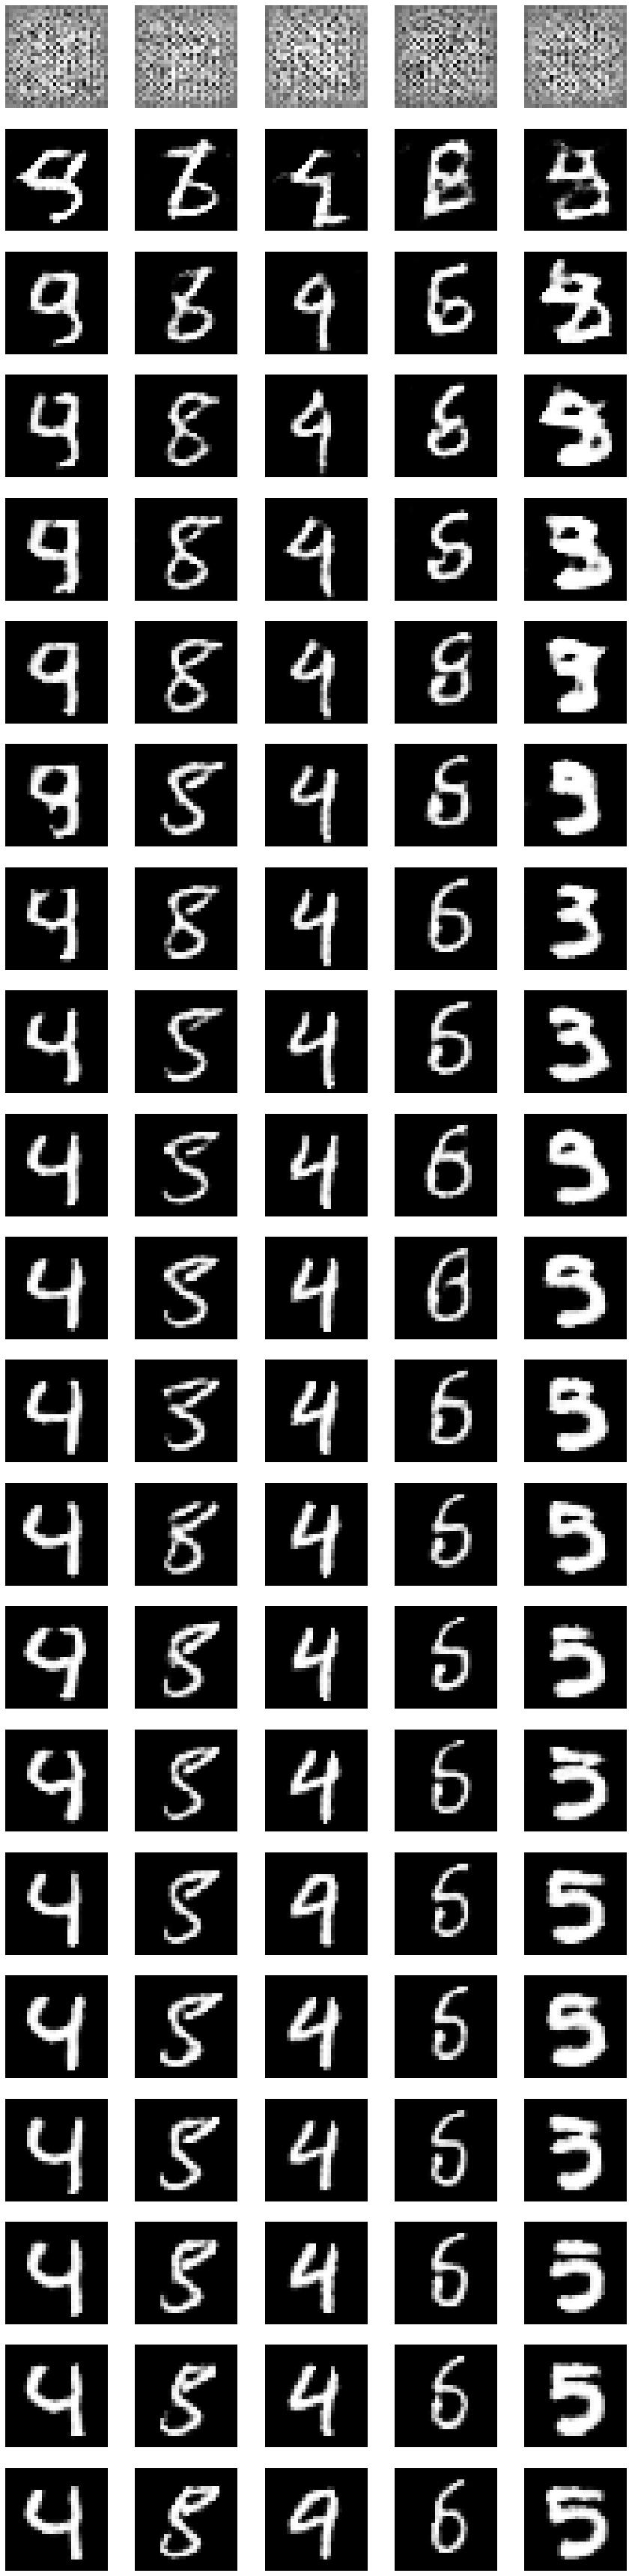

In [10]:
fig, ax = plt.subplots(len(imgs), 5, figsize=(15, len(imgs) * 3))

for i in range(len(imgs) * 5):
    ax[i // 5, i % 5].imshow(imgs[i // 5][i % 5], cmap="gray")
    ax[i // 5, i % 5].axis("off")

tensor([0.8750, 0.7334, 0.5244, 0.8692, 0.2732, 0.8475, 0.8688, 0.9115, 0.6981,
        0.3752, 0.7672, 0.6685, 0.8538, 0.7049, 0.2874, 0.9143, 0.8905, 0.6368,
        0.5894, 0.6658, 0.8586, 0.1576, 0.9256, 0.5751, 0.9250],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


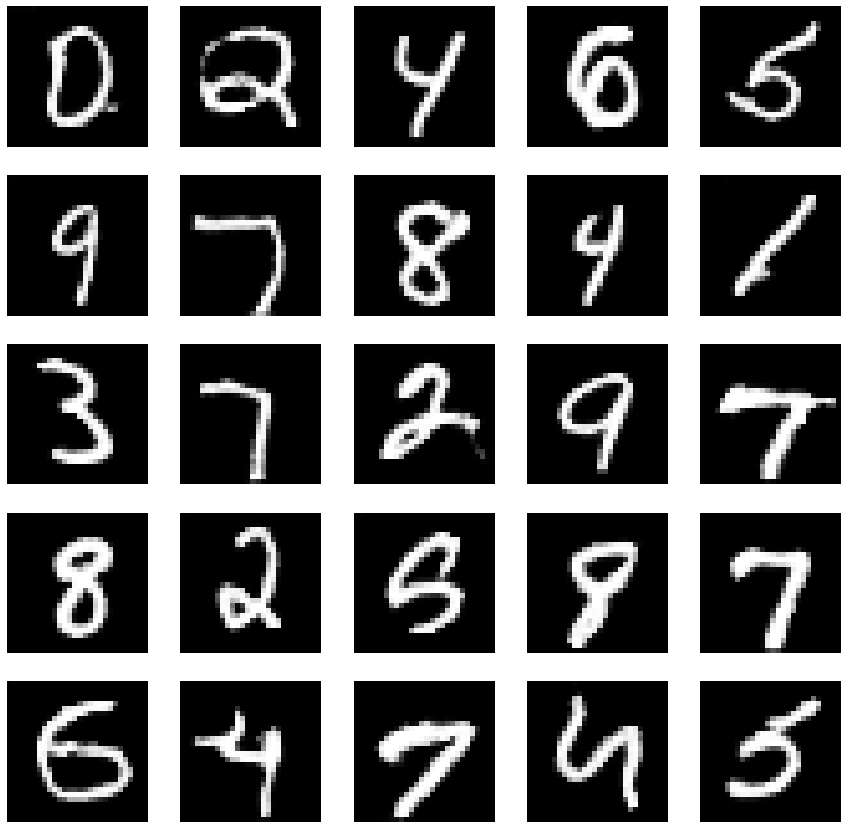

In [11]:
z = torch.normal(0, 1, size=(25, 100, 1, 1)).to(device)
out = generator(z).to("cpu").detach().numpy().reshape(-1, 28, 28)
print(discriminator(generator(z)))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    ax[i // 5, i % 5].imshow(out[i], cmap="gray")
    ax[i // 5, i % 5].axis("off")